In [18]:
import math
import pydicom
import numpy as np 
from PIL import Image
from scipy import ndimage
import matplotlib.pyplot as plt

In [17]:
# find line theta: jpg
img = Image.open("images/more_rotate.jpg").convert("L")
arr = np.array(img)
h, w = arr.shape

In [7]:
# Specify the path to your DICOM file
dicom_file_path = 'images/00000009'

# Read the DICOM file
dicom_data = pydicom.dcmread(dicom_file_path)
arr = dicom_data.pixel_array
h, w = arr.shape

In [8]:
def display(arr, axis=False) :
    plt.imshow(arr, cmap="gray")
    plt.axis(axis)

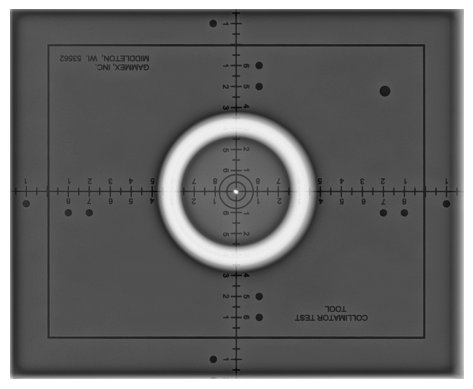

In [9]:
display(arr)

In [10]:
def find_center_line(arr, visualize=True) :
    """
    find center line
    Return: (x1, y1), (x2, y2)
    """
    h, w = arr.shape
    hp = int(0.15*h)
    wp = int(0.05*w)
    focus = arr[hp: h-hp, wp: wp*2]
    ys = np.argmin(focus, axis=0)
    unique_elements, counts = np.unique(ys, return_counts=True)
    most_common_index = np.argmax(counts)
    y1 = unique_elements[most_common_index] + hp # because focus start at hp not 0

    focus = arr[hp: h-hp, w-(wp*2): w-wp]
    ys = np.argmin(focus, axis=0)
    unique_elements, counts = np.unique(ys, return_counts=True)
    most_common_index = np.argmax(counts)
    y2 = unique_elements[most_common_index] + hp 

    if visualize :
        plt.figure(figsize=(3, 6))
        plt.subplot(1, 2, 1)
        display(arr[hp:h-hp, wp: wp*2], axis=True)
        plt.tick_params(bottom=False, labelbottom=False) # hide x-axis

        plt.subplot(1, 2, 2)
        display(arr[hp:h-hp, w-(wp*2): w-wp], axis=True)
        plt.tick_params(bottom=False, labelbottom=False)
        plt.suptitle(f"Center line is on \n{y1-hp} and {y2-hp} [y-axis]")

    return (0, y1), (w, y2)

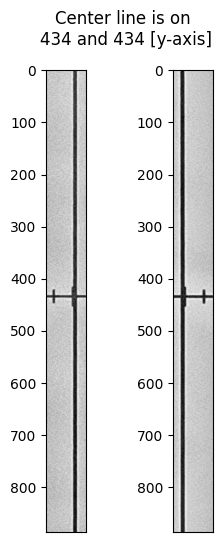

In [12]:
(x1, y1), (x2, y2) = find_center_line(arr)

In [13]:
def draw_line(arr, x1, y1, x2, y2) :
    plt.imshow(arr, cmap="gray")
    plt.plot([x1, x2], [y1, y2], color='blue', linewidth=1)
    plt.axis(False)

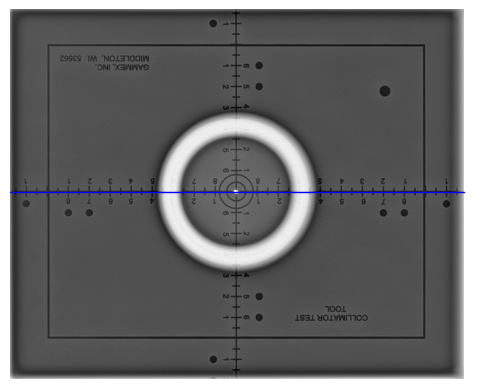

In [14]:
draw_line(arr, x1, y1, x2, y2)

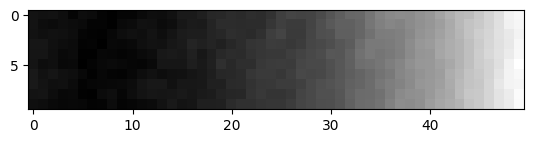

In [53]:
plt.imshow(arr[200: 210, 1500: 1550], cmap="gray")

In [58]:
f = arr[200: 205, 1500: 1550]
f

array([[ 7637,  7585,  7596,  7528,  7323,  7499,  7457,  7297,  7235,
         7323,  7315,  7429,  7515,  7491,  7582,  7787,  7775,  7891,
         8066,  8092,  8179,  8134,  8208,  8195,  8304,  8583,  8698,
         8654,  8691,  8834,  9047,  9241,  9453,  9462,  9741, 10026,
        10180, 10232, 10225, 10371, 10475, 10732, 10974, 11187, 11255,
        11509, 11767, 12031, 12439, 12549],
       [ 7620,  7506,  7454,  7528,  7479,  7430,  7303,  7295,  7249,
         7409,  7458,  7587,  7558,  7445,  7521,  7723,  7800,  7772,
         8003,  8174,  8181,  8149,  8176,  8159,  8380,  8584,  8500,
         8486,  8687,  8927,  9151,  9291,  9281,  9419,  9767,  9972,
        10104, 10059, 10216, 10359, 10448, 10631, 10890, 11194, 11448,
        11571, 11807, 12064, 12417, 12534],
       [ 7609,  7531,  7579,  7566,  7503,  7324,  7287,  7252,  7377,
         7490,  7552,  7514,  7627,  7510,  7643,  7802,  7852,  7837,
         8019,  8053,  8215,  8198,  8134,  8285,  8566,  86

In [15]:
def find_theta(w, y1, y2) :
    """
    find theta from y1, y2
    Return: theta in degree
    """
    a = y2-y1
    theta_r = math.asin(a/w)
    theta_d = math.degrees(theta_r)
    return theta_d

In [16]:
theta_d = find_theta(w, y1, y2)
theta_d

0.0

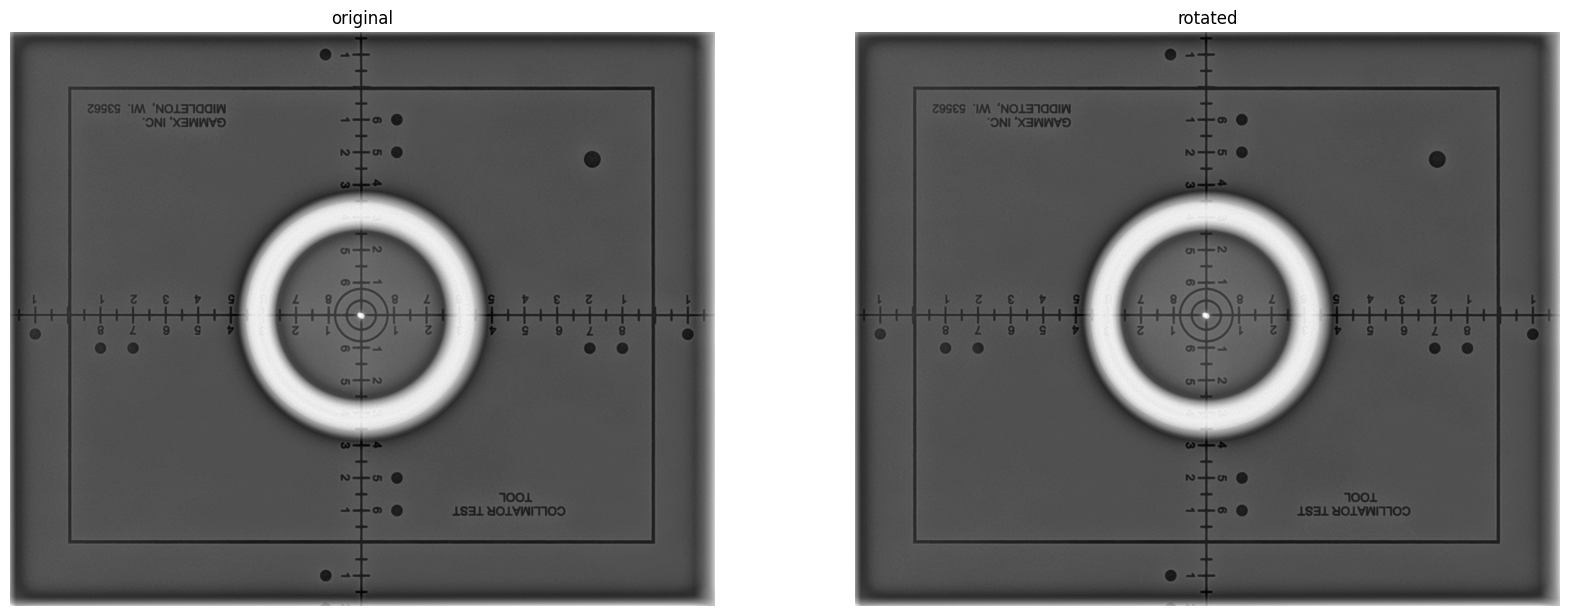

In [19]:
rotate_img = ndimage.rotate(arr, theta_d, reshape=False)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title("original")
display(arr)

plt.subplot(1, 2, 2)
plt.title("rotated")
display(rotate_img)